### DATA CLEANING - STEP 2

Please read data_cleaning_step1 for details about the initial steps for data analysis.
After investigatig further the data the following decisions were taken:

<b> Feature selection from clinical input: </b>
- ALP (Alkaline Phosphatase), ALT (Alanine Aminotransferase), and AST (Aspartate Aminotransferase) are all liver-related markers. They are relevant primarily for patients admitted due to liver issues. Among these, AST takes precedence over ALT and ALP.
- Cholesterol can be disregarded.
- DiasABP, MAP, NiDiasABP, NiMAP, NiSysABP, SySABP are all blood pressure variables. The focus should be on MAP (Mean Arterial Pressure), particularly prioritizing NiMAP (Non-Invasive Mean Arterial Pressure).
- Among troponins, only T is typically used, so Troponin I can be eliminated.
- For oxygenation-related parameters, FiO2 (Fraction of Inspired Oxygen) and PAO2 (Partial Pressure of Oxygen) are retained, with SaO2 (Oxygen Saturation) and RespRate (Respiration Rate) can be omitted.
  
<b> Feature extraction: </b>

- Remove outliers by calculating 4 * IQR. The reason behind this is that normally an outlier is consider as something that is above 1.5 IQR. In this case because we have ill patients we consider bigger IQR as plausible values.
- Create a feature BMI and remove from the dataframe Weight and Heigh
- For Mechanical ventilation assume Nan as no mechanical ventilation (assign this values to 0)
- For every time parameter extract:
   - median
   - median at 24 hours
   - median at 48 hours
   - normalized MAD
   - max
   - last value
   - slope (only extract if we have more than 15 data points in total available, in order to be able to calculate a good slope)

<b> Feature selection: </b> 
- Looking for features that are not representative and with excessive NaN values: Eliminate features where more than 40% of participants have missing values

- Look at correlations amongst features and also correlations amongst features and eliminate those features with a correlation > 0.8 

- Drop low variance features:  Zero or near-zero variance. Features that are (almost) constant provide little information to learn from and thus are irrelevant.
   

In [105]:
import pandas as pd
import pandas as pd
import glob
from pathlib import Path  # Importing the Path class from the pathlib module
import numpy as np
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os 
import math
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler

In [106]:
#GLOBAL VARIABLES
# Define the programmer whose path you want to use
programmer = 'esther'

#variables for paths names
file_paths_names = {
    'patricia': r"..\original_data",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data"
}

files_outcome_path_names = {
    'patricia': r"..\original_data\outcomes",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\data\outcomes"
}


files_path_to_save_files = {
    'patricia': r"..\clean_data",
    'esther': r"C:\Users\egh22\OneDrive - University of Canterbury\bootcamp\group project\clean_data"
}

# Choose the file path based on the programmer variable
file_path_to_save = files_path_to_save_files[programmer]


# VARIABLES FOR FEATURE REDUCTION
#threshold variables
#defines the number of std needed for a value to be considered out of range
threshold_for_outliers = 4
#defines the percentage of patients with NaNs for a feature  to be deleted from dataframe
thresholds_for_non_important_features = 50
#variance reduction threshold 
thresholds_variance_reduction = 0.02

In [107]:
def timeit(func):
    """
    Decorator function to measure the execution time of another function.

    Parameters:
        func (callable): The function to be decorated.

    Returns:
        callable: A wrapper function that measures the execution time of the decorated function.
    """
    def wrapper(*args, **kwargs):
        """
        Wrapper function that measures the execution time of the decorated function.

        Parameters:
            *args: Positional arguments to be passed to the decorated function.
            **kwargs: Keyword arguments to be passed to the decorated function.

        Returns:
            Any: The return value of the decorated function.
        """
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' elapsed time: {elapsed_time} seconds")
        return result
    return wrapper


In [108]:
@timeit
def process_time_series_files(time_series_files: list, all_parameters: list, non_time_parameters: list, categorical_parameters:list, summary_function: callable) -> pd.DataFrame:
    """
    Process a list of time series files and extract summary statistics for each file using a specified summary function.

    Parameters:
        time_series_files (list): A list of file paths to time series data files.
        all_parameters (list): A list of all parameters to calculate metrics for.
        non_time_parameters (list): A list of non-time parameters to extract values for.
        categorical_parameters (list): A list of special non-time parameters, that may appear more than once over time but always takes same value to extract values for.
        summary_function (callable): A function to calculate summary statistics for a DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing the summary statistics for all files.
    """
    results = []

    for file_path in time_series_files:
        # Read the file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Extract summary statistics for the DataFrame using the specified summary function
        result = summary_function(df, all_parameters, non_time_parameters, categorical_parameters)
        
        # Append the result to the results list
        results.append(result)

    # Concatenate results into a single DataFrame
    final_result = pd.concat(results, ignore_index=True)
    
    return final_result


In [109]:
# make a list with all time parameters in the dataset
time_parameters =  ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol', 
                    'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K',
                    'Lactate', 'Mg', 'MAP', 'Na', 'NIDiasABP', 'NIMAP', 'NISysABP', 'PaCO2', 
                 'PaO2',  'pH', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TropI', 'TropT', 'Urine', 'WBC',  'Weight']
time_parameters_original = time_parameters
non_time_parameters = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType']
demographic_parameters = non_time_parameters

categorical_parameters = ['MechVent']

# Concatenate all the lists
all_parameters = time_parameters + non_time_parameters + categorical_parameters

In [110]:
# Specify the file path using a raw string
#Modify path to your desired one
files_path = file_paths_names[programmer]

# Use glob to find all .txt files in the directory
time_series_files = glob.glob(str(Path(files_path) / "*.txt"))  # Using Path to construct the file path

# Print the number of files found
print(f"Number of text files: {len(time_series_files)}")
#delete this after demonstration
time_series_files_test = time_series_files[1]
#df = pd.read_csv(time_series_files[1])
time_series_files_test

Number of text files: 8000


'C:\\Users\\egh22\\OneDrive - University of Canterbury\\bootcamp\\group project\\data\\132540.txt'

In [111]:
# read target variables

#modify this with the name of the paths to read
files_outcome_path =  files_outcome_path_names[programmer]
df_target_a = pd.read_csv(Path(files_outcome_path) / "Outcomes-a.txt")
df_target_b = pd.read_csv(Path(files_outcome_path) / "Outcomes-b.txt")

outcomes_df = pd.concat([df_target_a, df_target_b], ignore_index=True)
outcome_columns = outcomes_df.columns.tolist()
outcome_columns.remove('RecordID')
outcomes_df

,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0
...,...,...,...,...,...,...
7995,152849,21,13,6,752,0
7996,152851,28,14,10,39,0
7997,152858,12,4,19,334,0
7998,152862,5,0,12,-1,0


### 1. Variable reduction


#### 1.1 Clinical judgement

In [112]:
variables_to_drop_by_clinical_judgement = ["TropI", "Cholesterol", "SaO2", "RespRate", "DiasABP", "NIDiasABP", "NISysABP", "SysABP"]
# Remove variables specified in variables_to_drop_by_clinical_judgement from time_parameters
time_parameters = [param for param in time_parameters if param not in variables_to_drop_by_clinical_judgement]


#### 1.2. Input nan in MechVent with 0

In [113]:
#Load dataset
result = pd.read_csv(os.path.join(file_path_to_save, 'result_for_data_cleaning.csv'))
# Extract columns from the DataFrame `result`
result_columns = result.columns

#impute Mech_vent Nan values with 0
result['MechVent'] = result['MechVent'].fillna(0)

# Filter out columns from result that do not contain any part of the feature names in time_parameters
result_filtered = result[[col for col in result.columns if any(feature in col for feature in time_parameters + non_time_parameters + categorical_parameters)]]
result = result_filtered

#### 1.2 More than 50% NaN values on the overall mean

In [114]:
# Assuming 'PatientID' is the common identifier, change it to whatever identifier you have
merged_df = result.merge(outcomes_df[['RecordID', 'In-hospital_death']], on='RecordID', how='left')

<b> Look at the distribution of missing values </b>

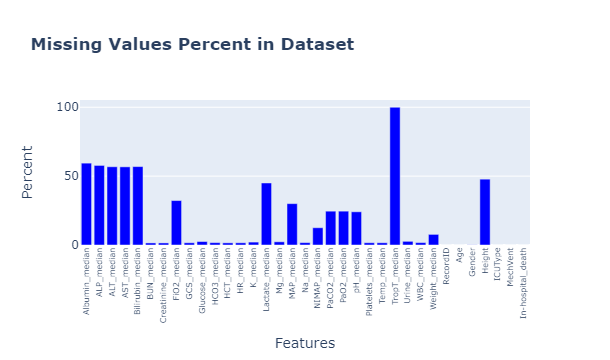

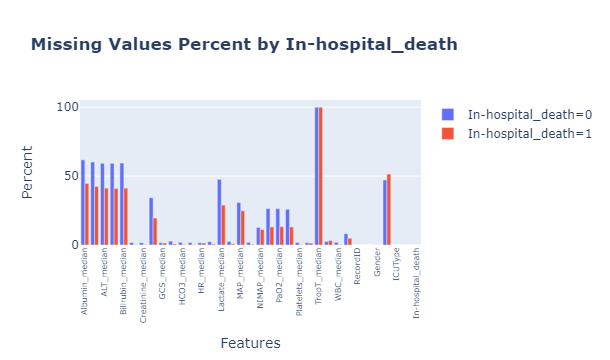

In [115]:
# From results data frame calculate the percentaje of NaNs
# Missing values plot
# Filter the DataFrame to include only features with '_mean' in their names

mean_features = [col for col in merged_df.columns if '_median' in col]
mean_features.extend(non_time_parameters)
mean_features.extend(categorical_parameters)
mean_features.extend(['In-hospital_death'])
# Calculate the total number of values for each mean feature
total_values = merged_df[mean_features].shape[0]


# Calculate the total number of values for each mean feature
total_values = merged_df[mean_features].shape[0]

# Calculate the number of NaN values for each mean feature
missing = merged_df[mean_features].isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / total_values) * 100
missing.index = missing['features']
del missing['features']

# Plot the percentage of NaN values in total
fig_total = go.Figure(data=[go.Bar(x=missing.index, y=missing['percent'], marker_color='blue')])
fig_total.update_layout(title='<b>Missing Values Percent in Dataset</b>',
                        xaxis_title='Features',
                        yaxis_title='Percent',
                        xaxis_tickangle=-90,  # Rotate x-axis labels for better visibility
                        )  # Adjust height of the plot as needed
fig_total.update_layout(xaxis=dict(tickfont=dict(size=8)))

# Plot the percentage of NaN values by 'In-hospital_death'
missing_grouped = merged_df.groupby('In-hospital_death')[mean_features].apply(lambda x: x.isna().sum() / len(x) * 100)
fig_by_death = go.Figure()
for death_value, missing_values in missing_grouped.iterrows():
    fig_by_death.add_trace(go.Bar(name=f'In-hospital_death={death_value}', x=missing_values.index, y=missing_values.values))

fig_by_death.update_layout(title='<b>Missing Values Percent by In-hospital_death</b>',
                           xaxis_title='Features',
                           yaxis_title='Percent',
                           xaxis_tickangle=-90,  # Rotate x-axis labels for better visibility
                           barmode='group')  # Adjust height of the plot as needed
fig_by_death.update_layout(xaxis=dict(tickfont=dict(size=8)))

# Show the plots
fig_total.show()
fig_by_death.show()

Filter columns with missing values > threshold

In [116]:
total_rows = len(result)
missing_values_percentage = (result.isnull().sum() / total_rows) * 100

# Create a DataFrame to store missing values percentage
missing_percentage_table = pd.DataFrame({
    'Feature': missing_values_percentage.index,
    'Missing Percentage': missing_values_percentage.values
})

# Sort missing percentage table by Missing Percentage column in descending order
missing_percentage_table_sorted = missing_percentage_table.sort_values(by='Missing Percentage', ascending=False)

# list features with missing values >50%

features_missing_gt_50
# Assuming you have the data stored in a DataFrame named df
feature_names_missing50 = features_missing_gt_50['Feature'].str.split('_', n=1).str[0].unique()
feature_names_missing50
print("Number of features missing more than 50% of values:", feature_names_missing50.shape[0])
print("NAme of features missing more than 50% of values:", feature_names_missing50)


Number of features missing more than 50% of values: 6
NAme of features missing more than 50% of values: ['TropT' 'Albumin' 'ALP' 'Bilirubin' 'ALT' 'AST']


In [117]:
# Remove this features from the time parameters
variables_to_drop_by_percentage = feature_names_missing50
# Remove variables specified in variables_to_drop_by_clinical_judgement from time_parameters
time_parameters = [param for param in time_parameters if param not in variables_to_drop_by_percentage]

# Convert the lists to sets
set_original = set(time_parameters_original)
set_filtered = set(time_parameters)

# Find the difference between the sets
difference = set_original.symmetric_difference(set_filtered)

# Print the difference and size of both lists
print("Difference between the lists:", difference)
print("Size of initial time parameters:", len(time_parameters_original))
print("Size of filtered time parameters:", len(time_parameters))

Difference between the lists: {'ALP', 'SaO2', 'Albumin', 'NISysABP', 'RespRate', 'SysABP', 'TropI', 'AST', 'TropT', 'ALT', 'NIDiasABP', 'Cholesterol', 'DiasABP', 'Bilirubin'}
Size of initial time parameters: 36
Size of filtered time parameters: 22


### 2. Feature extraction

For every time parameter extract:
   - median
   - median at 24 hours
   - median at 48 hours
   - normalized MAD
   - max
   - last value
   - slope

In [118]:
def extract_summarysed_features(df, time_parameters_filtered, demographic_parameters, categorical_parameters):
    """
    Generate new time summarised features based on different statistics and extract the values for demographic parameters, categorical parameters, 
    from the given DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing time-series data.
        time_parameters_filtered (list): A list of time-related parameters to extract statistics for.
        demographic_parameters (list): A list of demographic parameters to extract.
        categorical_parameters (list): A list of categorical parameters to extract.
    
    Returns:
        pd.DataFrame: A DataFrame containing the extracted values for demographic parameters,
                      categorical parameters, and various statistics for time parameters.
    """
    # Replace -1.0 with NaN
    df = df.replace(-1.0, np.nan)
    
    # Convert "Time" column to string
    df['Time'] = df['Time'].astype(str)
    
    # Extract hour from "Time" column
    df['Hour'] = df['Time'].str.split(':').str[0].astype(int)
    
    # Pivot the dataframe to have features as columns
    df_pivot = df.pivot_table(index='Hour', columns='Parameter', values='Value', aggfunc='median')
    
    # Create a new dataframe to store the extracted values
    new_df = pd.DataFrame()
    
    # Extract values for demographic parameters
    demographic_data = {}
    for feature in demographic_parameters:
        if feature in df_pivot.columns:
            demographic_data[feature] = df_pivot[feature].iloc[0]  # Extract the first value
        else:
            demographic_data[feature] = np.nan  # Feature not found, assign NaN
    demographic_df = pd.DataFrame(demographic_data, index=[0])

    # Extract values for categorical parameters
    categorical_data = {}
    for feature in categorical_parameters:
        if feature in df_pivot.columns:
            categorical_data[f'{feature}_start'] = df_pivot[df_pivot[feature].notna()].index.min()  # Extract the first value
            categorical_data[feature] = df_pivot.loc[df_pivot[df_pivot[feature].notna()].index.min(), feature]
        else:
            categorical_data[feature] = np.nan  # Feature not found, assign NaN
            categorical_data[f'{feature}_start'] = np.nan  # Feature not found, assign NaN
    categorical_df = pd.DataFrame(categorical_data, index=[0])

    
    # Extract median from 0-24, median from 25-48, overal_median, mad, max, slope and last_available value
    # for all time parameters
    time_data = {}
    
    for feature in time_parameters_filtered:
        if feature in df_pivot.columns:
            # Remove outliers for the slope calculation
            Q1 = df_pivot[feature].quantile(0.25)
            Q3 = df_pivot[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold_for_outliers * IQR
            upper_bound = Q3 + threshold_for_outliers * IQR
            df_pivot[feature] = df_pivot[feature].where((df_pivot[feature] >= lower_bound) & (df_pivot[feature] <= upper_bound))
             
            # Calculate median value for 0-24 hours
            time_data[f'{feature}_24median'] = df_pivot.loc[0:24, feature].median()
            # Calculate median value for 25-48 hours
            time_data[f'{feature}_48median'] = df_pivot.loc[25:48, feature].median()
            # Calculate overall median value
            time_data[f'{feature}_median'] = df_pivot[feature].median()
            # Calculate max value
            time_data[f'{feature}_max'] = df_pivot[feature].max()
            #calculate mad
            # Calculate mean absolute deviation (MAD) normalised
            # Calculate the absolute differences between each value and the median
            absolute_diff_median = (np.abs(df_pivot[feature] - df_pivot[feature].median())).median()
            # Calculate the median of these absolute differences
            time_data[f'{feature}_mad'] = ((absolute_diff_median/df_pivot[feature].median())*100) if df_pivot[feature].median() != 0 else np.nan
            # Calculate last available value
            time_data[f'{feature}_last'] = df_pivot[feature].dropna().iloc[-1] if not df_pivot[feature].isnull().all() else np.nan
            # Fit linear regression to the data
            # Flatten the data for the feature across all hours
            feature_values = df_pivot[feature].dropna().values
            all_hours = df_pivot[feature].dropna().index.values
            
            if len(all_hours) > 1:
                # Fit a linear regression line to the data
                coefficients = np.polyfit(all_hours, feature_values, 1)
                # Store the slope in the dataframe
                time_data[f'{feature}_slope'] = coefficients[0]
            else:
                # Insufficient data points for linear regression, assign NaN
                time_data[f'{feature}_slope'] = np.nan
           
        else:
             # Calculate median value for 0-24 hours
            time_data[f'{feature}_24median'] = np.nan
            time_data[f'{feature}_48median'] = np.nan
            time_data[f'{feature}_median'] = np.nan
            time_data[f'{feature}_max'] = np.nan
            time_data[f'{feature}_mad'] = np.nan
            time_data[f'{feature}_last'] = np.nan
            time_data[f'{feature}_slope'] = np.nan

    time_df = pd.DataFrame(time_data, index=[0])
 
    
    # Concatenate all dataframes along columns axis
    final_df = pd.concat([demographic_df, categorical_df, time_df], axis=1)
    
    return final_df

#Uncomment this to create file!!
#save dataframe for feature cleaning
result = process_time_series_files(time_series_files, time_parameters, demographic_parameters, categorical_parameters, extract_summarysed_features)
result.to_csv(os.path.join(file_path_to_save, "uncleaned_summarysed_features.csv"), index=False)

Function 'process_time_series_files' elapsed time: 387.9965877532959 seconds


In [119]:
final_dataframe = pd.read_csv(os.path.join(file_path_to_save, 'uncleaned_summarysed_features.csv'))
print("Number of columns after feature extraction:", final_dataframe.shape[1])

Number of columns after feature extraction: 161


In [120]:

#Create BMI value and drop 'Height', 'Weight_median'
final_dataframe['BMI'] = np.where(final_dataframe['Height'].isnull() | final_dataframe['Weight_median'].isnull(), np.nan, (final_dataframe['Weight_median'] / ((final_dataframe['Height'] / 100) ** 2)))
                               
#Add BMI to my demo features
demographic_parameters.append('BMI')
demographic_parameters.remove('Height')
#Reorder dataframe so that demo parameters go first 

# Get a list of all column names
columns = list(final_dataframe.columns)

# Move demographic parameters to the beginning of the list
for param in demographic_parameters[::-1]:
    columns.remove(param)
    columns.insert(0, param)

# Reorder the DataFrame columns
final_dataframe = final_dataframe[columns]
final_dataframe.drop(columns=['Height', 'Weight_median'], inplace=True)   
final_dataframe.head(5)

,RecordID,Age,Gender,ICUType,BMI,MechVent,MechVent_start,BUN_24median,BUN_48median,BUN_median,...,WBC_max,WBC_mad,WBC_last,WBC_slope,Weight_24median,Weight_48median,Weight_max,Weight_mad,Weight_last,Weight_slope
0,132539.0,54.0,0.0,4.0,NaN,NaN,NaN,13.0,8.0,10.5,...,11.2,8.737864,9.4,-0.078261,NaN,NaN,NaN,NaN,NaN,NaN
1,132540.0,76.0,1.0,2.0,26.228364,1.0,1.0,17.0,21.0,18.0,...,13.3,1.526718,13.3,0.126301,80.6,80.6,80.6,0.0,80.6,5.728184e-16
2,132541.0,44.0,0.0,3.0,NaN,1.0,10.0,5.5,3.0,3.0,...,6.2,11.904762,6.2,0.058981,56.7,56.7,56.7,0.0,56.7,-7.200356e-16
3,132543.0,68.0,1.0,3.0,26.024291,NaN,NaN,21.5,10.0,20.0,...,11.5,10.227273,7.9,-0.095192,84.6,84.6,84.6,0.0,84.6,-5.533244e-16
4,132545.0,88.0,0.0,3.0,NaN,NaN,NaN,45.0,25.0,35.0,...,4.8,11.627907,4.8,0.038462,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Feature Selection

##### Removing features with more than 50% NaN values

In [121]:
# Calculate percentage of missing values per feature
total_rows = len(final_dataframe)
missing_values_percentage = (final_dataframe.isnull().sum() / total_rows) * 100

# Create a DataFrame to store missing values percentage
missing_percentage_table = pd.DataFrame({
    'Feature': missing_values_percentage.index,
    'Missing Percentage': missing_values_percentage.values
})

# Sort missing percentage table by Missing Percentage column in descending order
missing_percentage_table_sorted = missing_percentage_table.sort_values(by='Missing Percentage', ascending=False)

# list features with missing values >50%
features_missing_gt_50 = missing_percentage_table_sorted[missing_percentage_table_sorted['Missing Percentage'] >= thresholds_for_non_important_features]
print("Number of features missing more than 50% of values:", features_missing_gt_50.shape[0])
# List the feature names
print("Name fo the features missing more than 50% of values:", features_missing_gt_50['Feature'].tolist())
features_missing_gt_50

Number of features missing more than 50% of values: 3
Name fo the features missing more than 50% of values: ['Lactate_48median', 'Lactate_slope', 'Lactate_24median']


,Feature,Missing Percentage
71,Lactate_48median,73.7875
76,Lactate_slope,63.1875
70,Lactate_24median,50.4500


In [122]:
# Create a boolean mask for features with missing percentage >= 70
mask = missing_values_percentage >= thresholds_for_non_important_features 
final_dataframe_filtered = final_dataframe.loc[:, ~mask]
print("Number of features after eliminating >50% missing features:", final_dataframe_filtered.shape[1])

Number of features after eliminating >50% missing features: 157


#### Removing low variance features

In [123]:
X = final_dataframe_filtered.drop(columns=demographic_parameters + categorical_parameters)

# Step 1: Scale your features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X
# Instantiate the VarianceThreshold object with the desired threshold
# Step 2: Use VarianceThreshold to select features based on variance
threshold = 0.05  # Set your desired threshold
sel = VarianceThreshold(threshold = thresholds_variance_reduction)
X_selection = sel.fit_transform(X_scaled)

# Get boolean mask of selected features
selected_columns_mask = sel.get_support()

# Get selected column names
selected_columns = X.columns[selected_columns_mask]

# Get dropped column names
dropped_columns = X.columns[~selected_columns_mask]

# Print selected and dropped column names
print("Selected columns:", selected_columns)
print("Dropped columns:", dropped_columns)

Selected columns: Index(['MechVent_start', 'BUN_24median', 'BUN_48median', 'BUN_median',
       'BUN_max', 'BUN_mad', 'BUN_last', 'BUN_slope', 'Creatinine_24median',
       'Creatinine_48median',
       ...
       'WBC_median', 'WBC_max', 'WBC_mad', 'WBC_last', 'WBC_slope',
       'Weight_24median', 'Weight_48median', 'Weight_max', 'Weight_mad',
       'Weight_last'],
      dtype='object', length=142)
Dropped columns: Index(['Creatinine_slope', 'FiO2_slope', 'GCS_slope', 'HCO3_slope',
       'HCT_slope', 'K_slope', 'Mg_slope', 'Temp_slope', 'Weight_slope'],
      dtype='object')


In [124]:
final_dataframe_filtered = final_dataframe_filtered.drop(columns=dropped_columns.tolist())
print("Number of columns after low variance dropped:", final_dataframe_filtered.shape[1])

Number of columns after low variance dropped: 148


#### Removing high correlated features

In [125]:
dataframe_4correlation = final_dataframe_filtered.drop(columns=demographic_parameters + categorical_parameters)

#Re-order the dataframe so that we prioritize keeping the median features just because it is easy to interprete later
median_cols = [col for col in dataframe_4correlation.columns if col.endswith("_median")]
non_median_cols = [col for col in dataframe_4correlation.columns if not col.endswith("_median")]
ordered_cols = median_cols + non_median_cols

# Create the reordered DataFrame
dataframe_4correlation_reordered = dataframe_4correlation[ordered_cols]


In [126]:
# Calculate correlation matrix

corr_matrix = dataframe_4correlation_reordered.corr().abs()
# Set upper triangle of correlation matrix to NaN
corr_matrix.values[np.triu_indices_from(corr_matrix)] = np.nan

# Find highly correlated features
highly_correlated_features = set()
for col in corr_matrix.columns:
    correlated_cols = corr_matrix[col][corr_matrix[col] > 0.8].index.tolist()
    #print(col, ",", correlated_cols)
    # Drop the first column in each pair of highly correlated features
    highly_correlated_features.update(correlated_cols)

final_dataframe = final_dataframe_filtered.drop(columns=highly_correlated_features)


In [127]:
# Calculate correlation matrix

corr_matrix = dataframe_4correlation_reordered.corr().abs()
# Set upper triangle of correlation matrix to NaN
corr_matrix.values[np.triu_indices_from(corr_matrix)] = np.nan

# Find highly correlated features
highly_correlated_features = set()
for col in corr_matrix.columns:
    correlated_cols = corr_matrix[col][corr_matrix[col] > 0.8].index.tolist()
    #print(col, ",", correlated_cols)
    # Drop the first column in each pair of highly correlated features
    highly_correlated_features.update(correlated_cols)

print(highly_correlated_features)

{'PaCO2_24median', 'Platelets_last', 'Urine_48median', 'Urine_24median', 'BUN_48median', 'Mg_24median', 'NIMAP_24median', 'Platelets_max', 'Creatinine_48median', 'Lactate_max', 'BUN_max', 'WBC_24median', 'NIMAP_48median', 'FiO2_last', 'HR_last', 'PaO2_last', 'Mg_last', 'MAP_24median', 'FiO2_48median', 'WBC_max', 'Na_last', 'HCT_24median', 'HR_24median', 'HCT_last', 'Temp_24median', 'HCT_max', 'Glucose_last', 'Weight_48median', 'MAP_48median', 'Na_24median', 'Platelets_48median', 'HCO3_last', 'HR_48median', 'Lactate_last', 'Na_48median', 'pH_48median', 'Creatinine_last', 'Platelets_24median', 'HCO3_24median', 'Weight_max', 'BUN_last', 'PaCO2_48median', 'K_last', 'K_24median', 'PaO2_24median', 'GCS_max', 'GCS_24median', 'HCT_48median', 'pH_24median', 'Na_max', 'PaCO2_last', 'GCS_last', 'Creatinine_max', 'pH_last', 'FiO2_24median', 'HCO3_48median', 'WBC_48median', 'Creatinine_24median', 'BUN_24median', 'WBC_last', 'GCS_48median', 'Weight_last', 'Mg_48median', 'PaCO2_max', 'pH_slope', 'pH_

In [128]:
print("Number of columns after correlation features dropped:", final_dataframe.shape[1])

Number of columns after correlation features dropped: 80


In [129]:
#save dataframe 
final_dataframe.to_csv(os.path.join(file_path_to_save, "clean_dataframe_with_NaN.csv"), index=False)

Now we have our final df saved and ready for next step : NaN imputation